
**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Trabajo práctico entregable - Parte 1

In [1]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

seaborn.set_context('talk')
seaborn.set_theme(style='ticks')

## Lectura del dataset

En la notebook *00* se explican los detalles de la siguiente sección.

In [2]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

In [3]:
df[:3]

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,...,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city
0,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,3.0,3.0,3.0,0,Universitario,En curso,...,En mi trabajo actual,Homosexual,NaN,NaN,501-1000,Servicios / Consultoría de Software / Digital,7,2,"Capacitaciones y/o cursos, Comidas pagas / sub...",NaN
1,Hombre,29,Argentina,Corrientes,5.0,2.0,2.0,4,Universitario,En curso,...,Jamás,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN
2,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,2.0,0.0,0.0,0,Secundario,Completado,...,En un trabajo anterior,Bisexual o queer,NaN,No,2001-5000,Otras industrias,6,9,"Clases de gimnasia online, Comidas pagas / sub...",NaN


# Ejercicio 2 - Densidades y varias variables

Responder a la pregunta general: **¿Qué herramientas (prácticas y/o teóricas) son útiles para explorar la base, y descubrir patrones o asociaciones?**

Para ello considere (igual al ejercicio anterior):

1. Seleccionar las columnas relevantes para analizar.

**Respuesta**
Dejando de lado los lenguajes de programación del ejercicio anterior, se procede a elegir las siguientes columnas
- Variables Numéricas: `salary_monthly_NETO`, `salary_monthly_BRUTO`, y `profile_age`.
- Variables Categóricas: `profile_open_source_contributions`, y `salary_in_usd`.
- Variables Ordinales: `profile_studies_level`, y `profile_studies_level_state` (también podría ser categórica).

2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en sub-poblaciones.

**Respuesta**
Observando los datos se pudo apreciar la existencia de valores *NaN* y erróneos, por lo que se procedió a eliminar los valores nulos y los menores a 10000 que existían en la columna `salary_monthly_NETO`.
Para los valores extremos superiores, se procedió a eliminar los mayores al percentil 99, entendiendo que esto genera un sesgo en la media muestral.
Un razonamiento idéntico se aplica para la columna `salary_monthly_BRUTO`.
En el caso de las columnas adicionales se procedió de la siguiente manera
- Se eliminan las filas con edades mayores a 100 años en `profile_age`, ya que carecen de sentido.
- Se aplica una transformación a los valores de `salary_in_usd`, para poder trabajar con valores *booleanos* en lugar de *strings*.

### 1. Selección de Columnas Relevantes

In [4]:
# Constantes Auxiliares.

# Numéricas
neto = 'salary_monthly_NETO'
bruto = 'salary_monthly_BRUTO'
edad = 'profile_age'
experiencia = 'profile_years_experience'
# Categóricas
dolares = 'salary_in_usd'
contrato = 'work_contract_type'
work_province = 'work_province'
open_source = 'profile_open_source_contributions'
# Ordinales
nivel = 'profile_studies_level'
estado = 'profile_studies_level_state'

# Selección de Columnas Relevantes.
relevant_columns = [neto, bruto, edad, contrato, dolares, nivel, estado, experiencia, open_source, work_province]

print(df.columns)

Index(['profile_gender', 'profile_age', 'work_country', 'work_province',
       'profile_years_experience', 'work_years_in_company',
       'work_years_in_current_position', 'work_people_in_charge_of',
       'profile_studies_level', 'profile_studies_level_state',
       'profile_career', 'profile_university',
       'profile_specialization_courses', 'profile_open_source_contributions',
       'profile_programming_as_hobby', 'work_role', 'tools_platform',
       'tools_programming_languages', 'tools_frameworks', 'tools_data_bases',
       'tools_qa_testing', 'tools_IDEs', 'tools_work_pc_os',
       'tools_cellphone_os', 'work_on_call_duty', 'salary_on_call_duty_charge',
       'work_on_call_duty_charge_type', 'work_contract_type',
       'salary_monthly_BRUTO', 'salary_monthly_NETO', 'salary_in_usd',
       'salary_satisfaction', 'salary_comparison_last_semester',
       'salary_has_bonus', 'salary_bonus_tied_to',
       'salary_inflation_adjustment_2020',
       'salary_percentage_inf

### 2. Selección de Filas Relevantes

In [5]:
def filter_experiencie_years(df, over):
    """
    Filter rows that are over `over` parameter.
    """
    df_new = df.copy(deep=True)
    devs_over = len(df_new[df_new[experiencia] >= over])
    print(f'Developers por encima de {over} años de experiencia: {devs_over}')
    df_new = df_new[df_new[experiencia] >= over].copy(deep=True)
    return df_new


def filtrar_salarios(df, salario):
    """
    Dada una columna de salarios, aplica una serie de filtros al df.
    """

    # ¿Cuántos NaN existen en la columna de salarios?
    print(f'Cantidad de salarios nulos: {df[salario].isna().sum()}')
    # Limpieza de valores nulos.
    df.dropna(subset=[salario], inplace=True)

    # Salario Mínimo para la subpoblación de estudio.
    min_salary = 10000
    # ¿Cuántos salarios erróneos existen en la columna de salarios?
    print(f'Cantidad de salarios <= 10K: {(df[salario] <= min_salary).sum()}')
    # Considerando el salario mínimo.
    df = df[df[salario] > min_salary].copy(deep=True)

    # Salario Máximo para la subpoblación de estudio (Percentil 99).
    max_salary = df[salario].quantile(0.99)
    print(f'Percentil 99: {max_salary}')
    # ¿Cuántos salarios son anómalos en la columna de salarios?
    print(f'Cantidad de salarios anómalos: {(df[salario] >= max_salary).sum()}')
    # Considerando el salario del percentil 99.
    df = df[df[salario] < max_salary].copy(deep=True)

    return df

In [6]:
print('Filtrado según salario BRUTO:')
df = filtrar_salarios(df, bruto)
print('----------')

print('Filtrado según salario NETO:')
df = filtrar_salarios(df, neto)
print('----------')

# Datos Muestrales (sobre el salario NETO y el salario BRUTO).
print(df[[neto, bruto]].describe())

Filtrado según salario BRUTO:
Cantidad de salarios nulos: 0
Cantidad de salarios <= 10K: 197
Percentil 99: 641939.2999999978
Cantidad de salarios anómalos: 59
----------
Filtrado según salario NETO:
Cantidad de salarios nulos: 197
Cantidad de salarios <= 10K: 61
Percentil 99: 400000.0
Cantidad de salarios anómalos: 59
----------
       salary_monthly_NETO  salary_monthly_BRUTO
count          5522.000000           5522.000000
mean          88651.609779         114537.589643
std           53566.195077          74585.652842
min           10700.000000          10602.410000
25%           54000.000000          64925.000000
50%           79000.000000          96009.000000
75%          105000.000000         140000.000000
max          396000.000000         609000.000000


In [7]:
# Edad Máxima para la subpoblación de estudio.
max_age = 65
# ¿Cuántas edades erróneas existen en la columna de edades?
print(f'Cantidad de edades >= {max_age}: {(df[edad] >= max_age).sum()}')
# Considerando la edad máxima.
df = df[df[edad] < max_age]
print('----------')

# Datos Muestrales (sobre la edad).
print(df[edad].describe())

Cantidad de edades >= 65: 4
----------
count    5518.000000
mean       32.530446
std         7.230988
min        18.000000
25%        27.000000
50%        31.000000
75%        37.000000
max        64.000000
Name: profile_age, dtype: float64


In [8]:
print(f'Posibles valores de VA: {df[dolares].unique()}')
# Por razones de comodidad, queremos trabajar con valores booleanos en esta columna.
df[dolares] = df[dolares].notna()
print(f'Posibles valores de VA: {df[dolares].unique()}')
print('----------')

# Datos Muestrales (sobre el salario en dólares).
print(df[dolares].describe())

Posibles valores de VA: [nan 'Mi sueldo está dolarizado']
Posibles valores de VA: [False  True]
----------
count      5518
unique        2
top       False
freq       4990
Name: salary_in_usd, dtype: object


In [9]:
# Nos quedamos con las columnas que analizaremos.
df = df[relevant_columns]

print(f'Dimensiones del DF: {df.shape}')
df[:5]

Dimensiones del DF: (5518, 10)


,salary_monthly_NETO,salary_monthly_BRUTO,profile_age,work_contract_type,salary_in_usd,profile_studies_level,profile_studies_level_state,profile_years_experience,profile_open_source_contributions,work_province
0,43000.0,53000.0,26,Full-Time,False,Universitario,En curso,3.0,No,Ciudad Autónoma de Buenos Aires
1,63000.0,79000.0,29,Full-Time,False,Universitario,En curso,5.0,No,Corrientes
2,127000.0,160000.0,22,Full-Time,False,Secundario,Completado,2.0,No,Ciudad Autónoma de Buenos Aires
3,102000.0,130000.0,39,Full-Time,False,Posgrado,Incompleto,15.0,Sí,Corrientes
4,106000.0,140000.0,32,Full-Time,False,Universitario,En curso,9.0,No,Ciudad Autónoma de Buenos Aires


## a) Densidad conjunta

¿Qué herramientas visuales y modelos puede utilizar para estudiar la distribución y comportamiento de sus datos? 

Elija tres variables **numéricas** y dos variables **categóricas**. Visualice la base según varias de las variables elegidas. ¿Puede describir de alguna forma el comportamiento de sus datos? ¿Qué herramientas utilizaría? Describa.

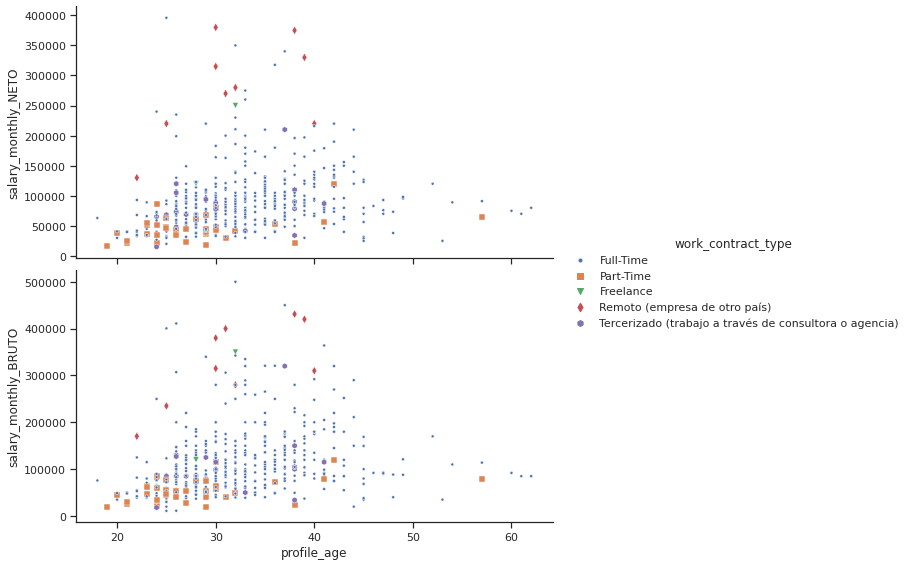

In [10]:
order = [ 'Full-Time'
        , 'Part-Time'
        , 'Freelance'
        , 'Remoto (empresa de otro país)'
        , 'Tercerizado (trabajo a través de consultora o agencia)'
        ]

# Para evitar superposición de puntos, solo se grafica una muestra de los datos.
seaborn.pairplot(data=df.sample(500),
                 x_vars=edad,
                 y_vars=[neto, bruto],
                 hue=contrato,
                 hue_order=order,
                 markers=['.', 's', 'h', 'd', 'v'],
                 aspect=2, height=4);

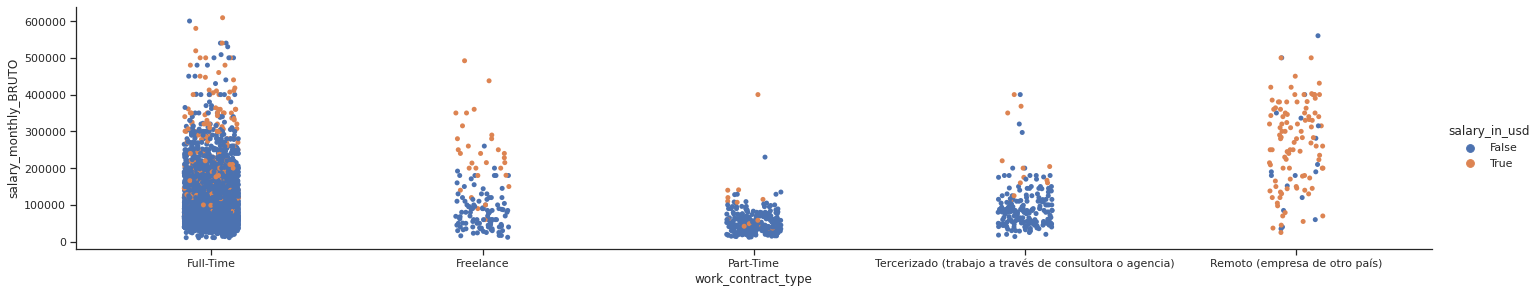

In [11]:
seaborn.catplot(data=df,
                x=contrato,
                y=bruto,
                hue=dolares,
                aspect=5, height=4);

**Respuesta**

...

## b) Asociación

Necesitamos decidir si sacar o no la columna de salario bruto, para hacer la encuesta más simple.
¿Existe una correlación entre el salario bruto y el salario neto? ¿Qué abordaje y medidas utilizaría?

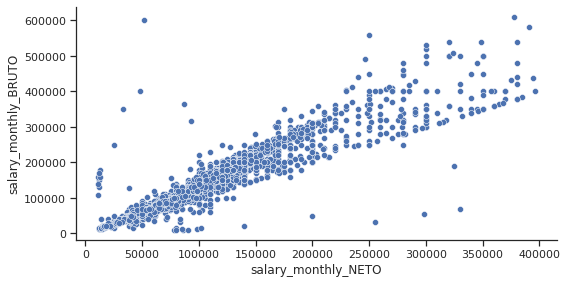

In [12]:
seaborn.pairplot(data=df,
                 x_vars=neto,
                 y_vars=bruto,
                 aspect=2, height=4);

In [13]:
# Calculo la correlación entre las columnas de salarios NETO y BRUTO.
df[[neto, bruto]].corr()

,salary_monthly_NETO,salary_monthly_BRUTO
salary_monthly_NETO,1.000000,0.941113
salary_monthly_BRUTO,0.941113,1.000000


**Respuesta**

El *pairplot* nos permite realizar de forma conjunta los gráficos de dispersión para todas las combinaciones de dos *features* sacados de un conjunto de *features* de interés.
En nuestro caso, solo nos interesan estudiar las variables aleatorias correspondientes a los salarios **bruto** y **neto**.
El gráfico nos permite obtener, entre otras cosas, una primera indicación de la *correlación* entre ambos features.
Se puede apreciar que la dispersión de los puntos se asemeja a la recta $x = y$.

Acompañando al gráfico, calculamos la **tabla de correlación** de ambas variables, obteniendo un valor muy cercano a uno.
Lo cual implica que existe una *correlación positiva* entre ambos *features*.

En definitiva, claramente hay una *correlación* entre ambas variables, por lo que **no** son independientes.
Por nuestro conocimiento sobre el tema, sabemos que en situaciones normales el salario neto de una persona debería ser equivalente al salario bruto descontado un cierto porcentaje, por lo que el resultado obtenido era esperable.

## c) Densidad condicional 

Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija **dos** subpoblaciones numerosas), y grafique de manera comparativa ambos histogramas de la variable `salary_monthly_NETO`.
¿Considera que ambas variables son independientes?
¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación.

In [14]:
sorted_studies_levels = [ 'Primario'
                        , 'Secundario'
                        , 'Terciario'
                        , 'Universitario'
                        , 'Posgrado'
                        , 'Doctorado'
                        , 'Posdoctorado'
                        ]

sorted_studies_state = [ 'En curso'
                       , 'Incompleto'
                       , 'Completado'
                       ]

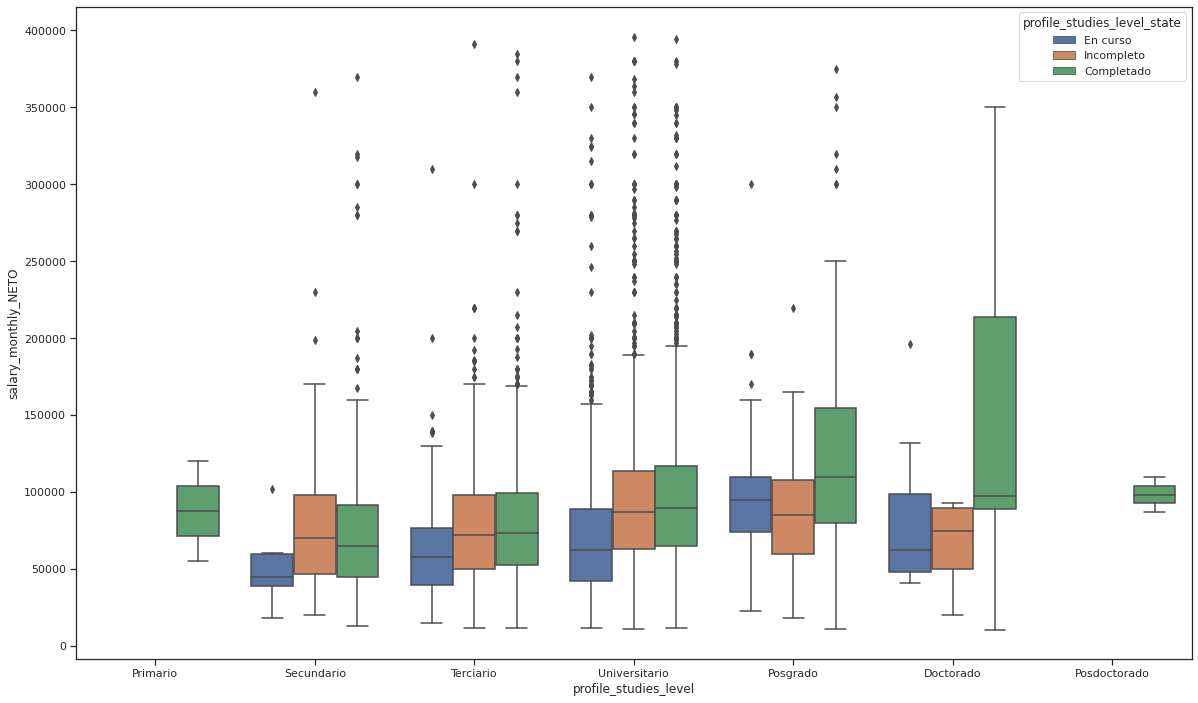

In [15]:
plt.figure(figsize=(20, 12))

seaborn.boxplot(data=df,
                x=nivel,
                y=neto,
                hue=estado,
                hue_order=sorted_studies_state,
                order=sorted_studies_levels);

In [16]:
# Averiguamos las subpoblaciones más numerosas.
df[nivel].value_counts()[sorted_studies_levels]

Primario            2
Secundario        404
Terciario        1035
Universitario    3750
Posgrado          299
Doctorado          26
Posdoctorado        2
Name: profile_studies_level, dtype: int64

In [17]:
new_groups = {
    'Primario': 'Pre-Universidad',
    'Secundario': 'Pre-Universidad',
    'Terciario': 'Pre-Universidad',
    'Universitario': 'Post-Universidad',
    'Posgrado': 'Post-Universidad',
    'Doctorado': 'Post-Universidad',
    'Posdoctorado': 'Post-Universidad'
}

sorted_studies = ['Pre-Universidad', 'Post-Universidad']

s_studies = df[nivel].replace(new_groups)

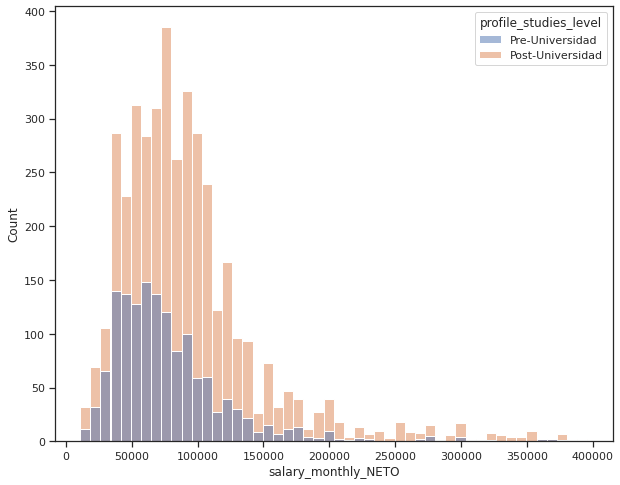

In [18]:
fig = plt.figure(figsize=(10, 8))

seaborn.histplot(df,
                 x=neto,
                 hue=s_studies,
                 hue_order=sorted_studies,
                 bins=50);

**Respuesta**

...

## d) Densidad conjunta condicional

Elija dos variables **numéricas** y una variable **categórica**.
Estudie la dispersión (*scatterplot*) de las dos variables numéricas, discriminando en color por la variable categórica (**hue** en *seaborn*).

Developers por encima de 4.0 años de experiencia: 4000


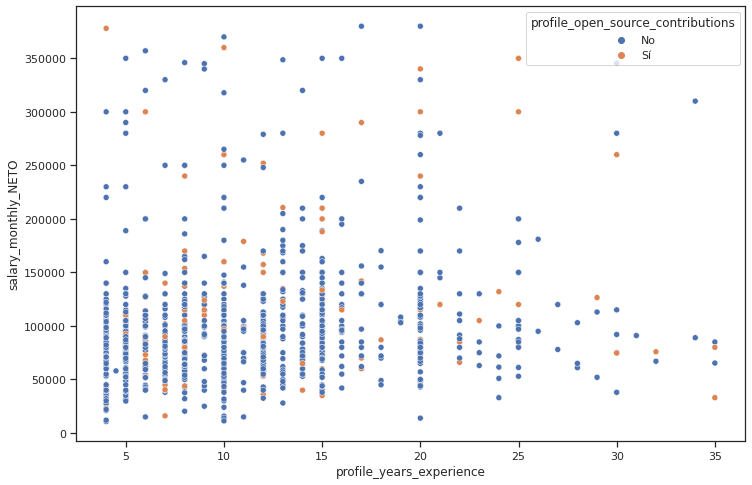

In [19]:
# Filtering junior positions (understanding that <= 4 years is considered junior position).
df = filter_experiencie_years(df, 4.0)
plt.figure(figsize=(12, 8))

seaborn.scatterplot(data=df.sample(1000),
                    x=experiencia,
                    y=neto,
                    hue=open_source);

In [20]:
# Segmentando los años de experiencia.

def to_categorical(column, bin_size=5, min_cut=4, max_cut=30):
    if min_cut is None:
        min_cut = int(round(column.min())) - 1
    value_max = int(np.ceil(column.max()))
    max_cut = min(max_cut, value_max)
    intervals = [(x, x + bin_size) for x in range(min_cut, max_cut, bin_size)]
    if max_cut != value_max:
        # Ugly fix
        intervals.append((max_cut+bin_size, value_max))
    print(intervals)
    return pd.cut(column, pd.IntervalIndex.from_tuples(intervals))

df[experiencia] = df[experiencia].astype(int)
df['years_experience_segment'] = to_categorical(df[experiencia])
pd.crosstab(df.years_experience_segment, df[open_source], normalize=False)

[(4, 9), (9, 14), (14, 19), (19, 24), (24, 29), (29, 34), (35, 115)]


profile_open_source_contributions,No,Sí
years_experience_segment,,
"(4, 9]",1150,182
"(9, 14]",982,140
"(14, 19]",511,89
"(19, 24]",316,60
"(24, 29]",107,27
"(29, 34]",44,17
"(35, 115]",3,4


**Respuesta**
- Variables Numéricas: `salary_monthly_NETO` y `profile_years_experience`.
- Variables Categóricas: `profile_open_source_contributions`

Se procedió a tomar la sub-población de personas que tienen 4 o más años de experiencia.

Partiendo desde la pseudo-hipótesis que las contribuciones al *open source* generan espacios de networking y posibilidades de trabajo en el extranjero, se esperaría que personas que contribuyan tengan mejores oportunidades y por lo tanto una tendencia a tener mejores salarios.

Tomando una muestra de longitud 1000, para tener un gráfico más legible, se puede notar que los puntos naranjas (desarrolladores que contribuyen al *open source*) están bastante dispersos y no se logra ver un patrón definido en su distribución.

Por lo tanto no podemos confirmar nuestra hipótesis siendo que los datos no nos muestran información suficiente. Aunque podrían sugerir una conocida situación en el mundo del *open source* donde aquellos encargados de mantener y desarrollar las herramientas para la comunidad en general no son retribuidos debidamente por su aporte. También estas personas son pocas en proporción a la muestra.